<a href="https://colab.research.google.com/github/Ankit035/Hybrid-LLM-for-Temporal-dataset/blob/main/HYBRID_MODEL_electricity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LightGBM + LLM Hybrid

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
!unzip LD2011_2014.txt.zip

--2025-04-29 06:49:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘LD2011_2014.txt.zip’

LD2011_2014.txt.zip     [        <=>         ] 249.23M  51.6MB/s    in 5.1s    

2025-04-29 06:49:24 (48.9 MB/s) - ‘LD2011_2014.txt.zip’ saved [261335609]

Archive:  LD2011_2014.txt.zip
  inflating: LD2011_2014.txt         
   creating: __MACOSX/
  inflating: __MACOSX/._LD2011_2014.txt  


In [ ]:
import pandas as pd

# Load data and resample daily
df = pd.read_csv('LD2011_2014.txt', sep=';', decimal=',', parse_dates=[0], index_col=0)
df = df.resample('D').sum()
daily_consumption = df[['MT_001']]  # Choose one meter for simplicity


#Feature Engineering

In [ ]:
import numpy as np

# Create features
features = pd.DataFrame(index=daily_consumption.index)
features['consumption'] = daily_consumption['MT_001']
features['day_of_week'] = features.index.dayofweek
features['month'] = features.index.month
features['is_weekend'] = features['day_of_week'].isin([5, 6]).astype(int)

# Lag features
features['lag_7'] = features['consumption'].shift(7)
features['lag_30'] = features['consumption'].shift(30)

# Rolling stats
features['rolling_7_mean'] = features['consumption'].rolling(7).mean()
features['rolling_30_std'] = features['consumption'].rolling(30).std()

# Fourier features
days = np.arange(len(features))
features['sin_annual'] = np.sin(2 * np.pi * days / 365)
features['cos_annual'] = np.cos(2 * np.pi * days / 365)

# Clean NaNs
features.dropna(inplace=True)


#LoRA Model Embedding (Simulated for now)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def extract_embedding(row):
    # Create a fake input string from date and features
    text = f"Day {int(row.day_of_week)}, Month {int(row.month)}, Consumption {row.consumption:.2f}"
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Extract embeddings and concatenate to features
embeddings = np.array([extract_embedding(row) for _, row in tqdm(features.iterrows(), total=len(features))])

# Add first 10 components as features (simulate low-rank LoRA)
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
embeddings_pca = pca.fit_transform(embeddings)

for i in range(embeddings_pca.shape[1]):
    features[f'llm_embed_{i}'] = embeddings_pca[:, i]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 1432/1432 [02:19<00:00, 10.28it/s]


#Train LightGBM Model

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

X = features.drop(columns=['consumption'])
y = features['consumption']

# Time-based split
split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Train
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4096
[LightGBM] [Info] Number of data points in the train set: 1145, number of used features: 19
[LightGBM] [Info] Start training from score 377.428901
RMSE: 105.68


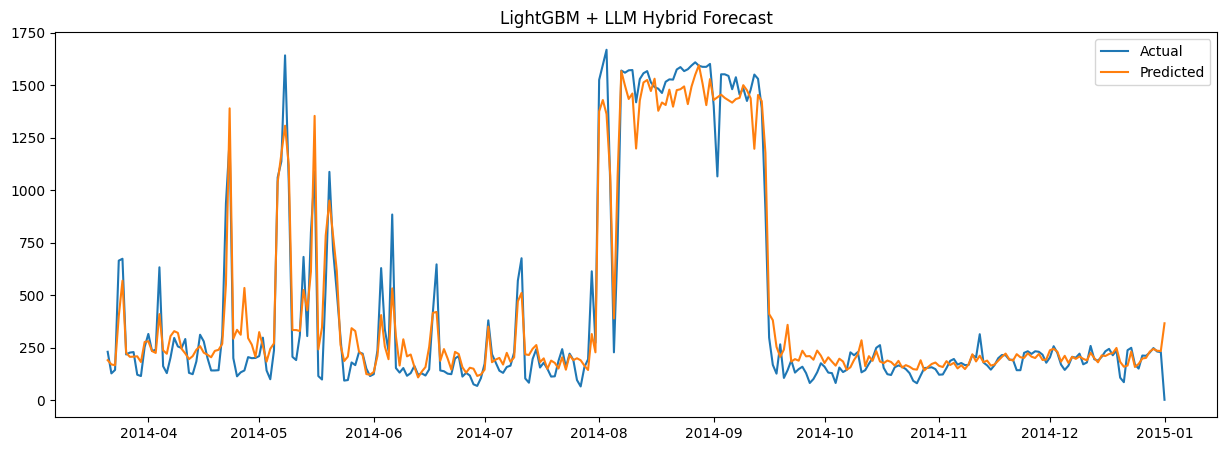

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("LightGBM + LLM Hybrid Forecast")
plt.legend()
plt.show()


#PREDICTION ACCURACY TERMS

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# True and predicted values
y_true = y_test
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Manual square root
r2 = r2_score(y_true, y_pred)

# Avoid divide by zero in MAPE
mape = (np.abs((y_true - y_pred) / y_true.replace(0, np.nan))).mean() * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 71.27
RMSE: 105.68
R² Score: 0.9550
MAPE: 80.09%


##PART-2

In [ ]:
import pandas as pd

# Load the dataset and parse dates
df = pd.read_csv('LD2011_2014.txt', sep=';', decimal=',', parse_dates=[0], index_col=0)

# Resample to daily totals
df = df.resample('D').sum()

# Select one meter (you can change this to another meter ID)
daily_consumption = df[['MT_001']]


In [ ]:
print(daily_consumption.head())

            MT_001
2011-01-01     0.0
2011-01-02     0.0
2011-01-03     0.0
2011-01-04     0.0
2011-01-05     0.0


In [ ]:
df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Time Series Feature Engineering

In [ ]:
import numpy as np

# Create base features
features = pd.DataFrame(index=daily_consumption.index)
features['consumption'] = daily_consumption['MT_001']
features['day_of_week'] = features.index.dayofweek
features['month'] = features.index.month
features['is_weekend'] = features['day_of_week'].isin([5, 6]).astype(int)

# Lag features
features['lag_7'] = features['consumption'].shift(7)
features['lag_30'] = features['consumption'].shift(30)

# Rolling statistics
features['rolling_7_mean'] = features['consumption'].rolling(7).mean()
features['rolling_30_std'] = features['consumption'].rolling(30).std()

# Fourier (seasonality) features
days = np.arange(len(features))
features['sin_annual'] = np.sin(2 * np.pi * days / 365)
features['cos_annual'] = np.cos(2 * np.pi * days / 365)

# Drop rows with NaN values (due to lag/rolling calculations)
features.dropna(inplace=True)


#Generate LLM-Based Embeddings (simulated with BERT)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

# Load a pre-trained BERT model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# Function to convert a row of features to a text string and get an embedding
def extract_embedding(row):
    text = f"Day {int(row.day_of_week)}, Month {int(row.month)}, Consumption {row.consumption:.2f}"
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Generate embeddings for each row
embeddings = np.array([extract_embedding(row) for _, row in tqdm(features.iterrows(), total=len(features))])


100%|██████████| 1432/1432 [02:20<00:00, 10.19it/s]


#Reduce Embedding Dimensionality and Add to Features

In [ ]:
from sklearn.decomposition import PCA

# Use PCA to reduce dimensions
pca = PCA(n_components=10)
embeddings_pca = pca.fit_transform(embeddings)

# Add embeddings to the features
for i in range(embeddings_pca.shape[1]):
    features[f'llm_embed_{i}'] = embeddings_pca[:, i]


#Split Data for Training and Testing

In [ ]:
from sklearn.model_selection import train_test_split

# Define X and y
X = features.drop(columns=['consumption'])
y = features['consumption']

# Time-based split (no shuffling for time series)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


#Train the LightGBM Model

In [ ]:
import lightgbm as lgb

# Train a LightGBM model
model_lgbm = lgb.LGBMRegressor()
model_lgbm.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4096
[LightGBM] [Info] Number of data points in the train set: 1145, number of used features: 19
[LightGBM] [Info] Start training from score 377.428901


LGBMRegressor()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict
y_pred = model_lgbm.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = (np.abs((y_test - y_pred) / y_test.replace(0, np.nan))).mean() * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE:  72.22
RMSE: 106.31
R²:   0.9545
MAPE: 77.21%


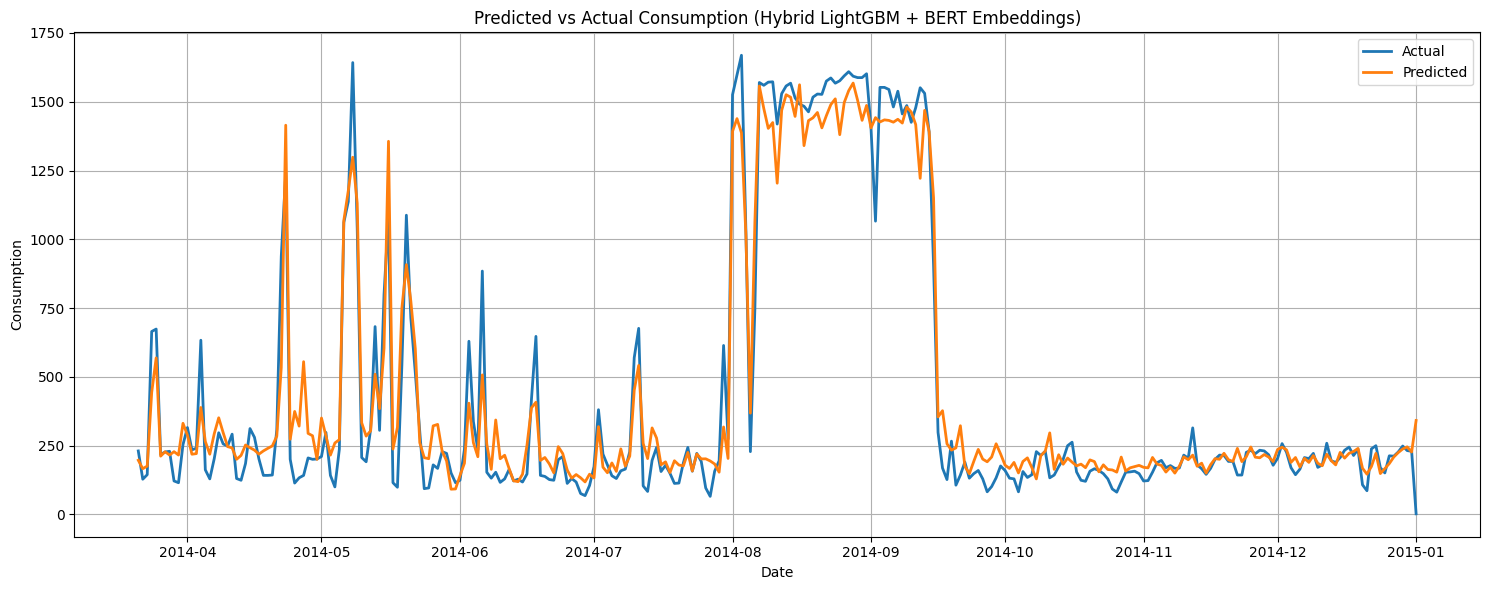

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred, label="Predicted", linewidth=2)
plt.title("Predicted vs Actual Consumption (Hybrid LightGBM + BERT Embeddings)")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Data Loading with Proper Datetime Handling

In [ ]:
import pandas as pd
import numpy as np

def load_data(filepath):
    df = pd.read_csv(
        filepath,
        sep=';',
        decimal=',',
        parse_dates=[0],
        index_col=0,
        thousands=None,
        encoding='utf-8'
    )

    # Convert all consumption columns to numeric (handling potential non-numeric values)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sum all columns to get total consumption (or you could keep individual clients)
    df['total_consumption'] = df.sum(axis=1)

    # Drop original columns if we're only using total consumption
    df = df[['total_consumption']]

    # Forward fill any missing values (common in time series)
    df.ffill(inplace=True)

    return df


# Feature Engineering

In [ ]:
import holidays

# 2. Feature Engineering
def create_features(df, target='total_consumption', lags=24*7):
    df = df.copy()

    # 2.1 Basic Time Features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear

    # 2.2 Cyclical Encoding
    def encode_cyclical(df, col, max_val):
        df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
        df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
        return df

    df = encode_cyclical(df, 'hour', 24)
    df = encode_cyclical(df, 'day_of_week', 7)
    df = encode_cyclical(df, 'month', 12)
    df = encode_cyclical(df, 'day_of_year', 365)

    # 2.3 Holidays in Portugal
    pt_holidays = holidays.Portugal()
    df['is_holiday'] = df.index.to_series().apply(lambda x: x in pt_holidays).astype(int)

    # 2.4 Weekend Flag
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    # 2.5 Time of Day Category
    df['time_of_day'] = pd.cut(df['hour'],
                               bins=[-1, 6, 12, 18, 23],
                               labels=['night', 'morning', 'afternoon', 'evening'])

    # 2.6 Season Encoding
    df['season'] = df['month'].apply(lambda month: (month % 12 + 3)//3)

    # 2.7 Rolling Statistics
    for window in [24, 24*7, 24*30]:  # 1 day, 1 week, 1 month
        df[f'rolling_mean_{window}'] = df[target].rolling(window=window, min_periods=1).mean()
        df[f'rolling_std_{window}'] = df[target].rolling(window=window, min_periods=1).std()
        df[f'rolling_min_{window}'] = df[target].rolling(window=window, min_periods=1).min()
        df[f'rolling_max_{window}'] = df[target].rolling(window=window, min_periods=1).max()

    # 2.8 Exponential Moving Averages
    for span in [24, 24*7]:  # 1 day, 1 week
        df[f'ema_{span}'] = df[target].ewm(span=span, adjust=False).mean()

    # 2.9 Lag Features
    for lag in [1, 2, 3, 24, 48, 24*7, 24*7*2]:
        df[f'lag_{lag}'] = df[target].shift(lag)

    # 2.10 Difference Features
    df['diff_1h'] = df[target].diff(1)
    df['diff_24h'] = df[target].diff(24)
    df['diff_1w'] = df[target].diff(24*7)

    # 2.11 Statistical Features by Date
    df['daily_mean'] = df.groupby(df.index.date)[target].transform('mean')
    df['weekly_mean'] = df.groupby([df.index.year, df.index.week])[target].transform('mean')

    # 2.12 Interaction Features
    df['hour_week_interaction'] = df['hour'] * df['day_of_week']
    df['hour_month_interaction'] = df['hour'] * df['month']

    # 2.13 Fourier Features for Seasonality
    for freq, order in [(24, 3), (24*365, 3)]:  # daily and yearly
        for i in range(1, order+1):
            df[f'fourier_sin_{freq}_{i}'] = np.sin(2 * i * np.pi * df.index.hour / freq)
            df[f'fourier_cos_{freq}_{i}'] = np.cos(2 * i * np.pi * df.index.hour / freq)

    # Drop raw time columns after encoding
    df.drop(['hour', 'day_of_week', 'month', 'day_of_year'], axis=1, inplace=True)

    # Remove rows with missing values (from lag/diff features)
    df.dropna(inplace=True)

    return df


#Data Preparation Pipeline

In [ ]:
from sklearn.preprocessing import StandardScaler

# 3. Data Preparation Pipeline
def prepare_data(filepath, target='total_consumption', test_size=0.2):
    # Step 1: Load data
    df = load_data(filepath)

    # Step 2: Feature engineering
    df = create_features(df, target=target)

    # Step 3: Extract target and features
    y = df[target]

    # Drop the target and categorical column (time_of_day) — you can encode it if needed
    X = df.drop([target, 'time_of_day'], axis=1)

    # Step 4: Time-based train-test split
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Step 5: Standardize numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, X.columns


In [ ]:
def create_sequences(X, y, time_steps=24):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Assume X_train and y_train are from your prepare_data function
X_seq_train, y_seq_train = create_sequences(X_train, y_train.values, time_steps=24)
X_seq_test, y_seq_test = create_sequences(X_test, y_test.values, time_steps=24)


#Build the TCN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.optimizers import Adam

def build_tcn_model(input_shape):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal', dilation_rate=1))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal', dilation_rate=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal', dilation_rate=4))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Final output

    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

# Build and train
model = build_tcn_model(input_shape=(X_seq_train.shape[1], X_seq_train.shape[2]))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 64)         │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,849 (495.50 KB)

 Trainable params: 126,849 (495.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_seq_train, y_seq_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_seq_test, y_seq_test),
    verbose=1
)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 57239.2344 - mae: 136.3707 - val_loss: 127124.7656 - val_mae: 227.3839
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 47187.7148 - mae: 121.4073 - val_loss: 132621.3438 - val_mae: 231.7639
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 43334.6133 - mae: 116.0082 - val_loss: 111474.4375 - val_mae: 212.7454
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 36594.5000 - mae: 103.5190 - val_loss: 143171.0000 - val_mae: 246.3262
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 39054.5898 - mae: 116.3392 - val_loss: 130167.9375 - val_mae: 228.1427
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 28565.6055 - mae: 100.3167 - val_loss: 138202.6406 - val_mae: 231.0935
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 36153.5898 - mae: 107.0231 - val_loss: 138175.2812 - val_mae: 235.5950
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 32315.5996 - mae: 100.6234 - va

In [ ]:
y_pred_tcn = model.predict(X_seq_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_seq_test, y_pred_tcn))
mae = mean_absolute_error(y_seq_test, y_pred_tcn)

print(f'TCN RMSE: {rmse:.2f}')
print(f'TCN MAE: {mae:.2f}')


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
TCN RMSE: 366.81
TCN MAE: 225.03


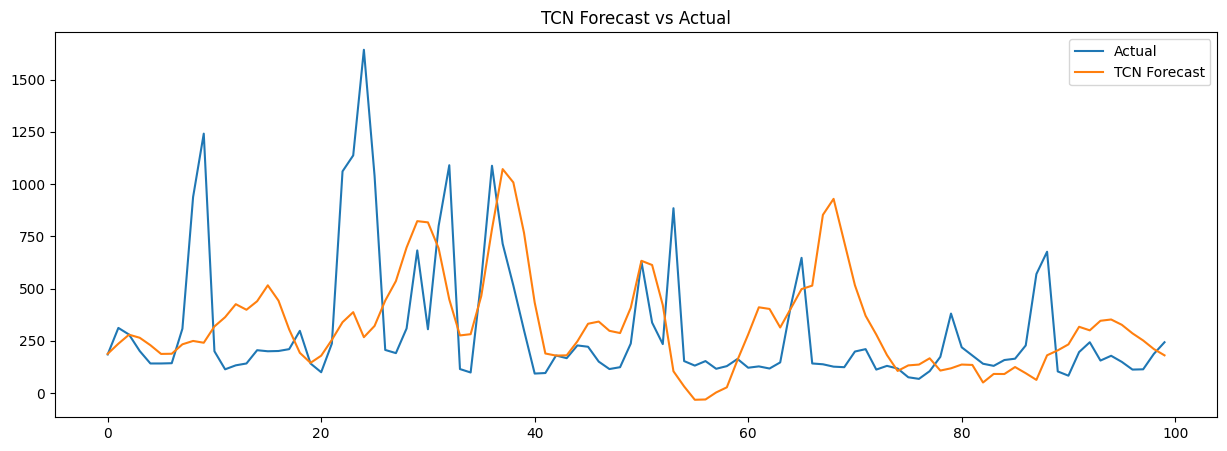

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(y_seq_test[:100], label='Actual')
plt.plot(y_pred_tcn[:100], label='TCN Forecast')
plt.title('TCN Forecast vs Actual')
plt.legend()
plt.show()


In [ ]:
!pip install nixtlats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install nixtla xgboost scikit-learn matplotlib pandas numpy

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from nixtla import NixtlaClient  # This is the correct import
import matplotlib.pyplot as plt

# Initialize Nixtla client with your API key
YOUR_NIXTLA_API_KEY = "nixak-XsLrLB5b9d3uWpUIVc6CFvmicUJlmd4zoDUajVEmQE6lwDljVLs2bsXc3LLIwzdFl3XT6PvihUS8SmPL"
nixtla_client = NixtlaClient(api_key=YOUR_NIXTLA_API_KEY)

In [ ]:
# TimeGPT Forecasting Section
print("Running TimeGPT forecasting...")

# Prepare data for TimeGPT - using your synthetic data structure
df_timegpt = df.copy()
df_timegpt['unique_id'] = 'ts_1'  # Add required unique_id column
df_timegpt = df_timegpt[['unique_id', 'ds', 'y']]  # Keep only required columns

try:
    # Get historical predictions (in-sample)
    historical = nixtla_client.historical(
        df=df_timegpt,
        freq='D',
        model='timegpt-1',
        time_col='ds',
        target_col='y'
    )

    # Merge predictions back to original dataframe
    df = df.merge(historical[['ds', 'TimeGPT']],
                 on='ds',
                 how='left')
    df = df.rename(columns={'TimeGPT': 'yhat'})

except Exception as e:
    print(f"Error calling TimeGPT API: {e}")
    print("Using simple mean as fallback")
    df['yhat'] = df['y'].mean()

# Calculate residuals (actual - predicted)
df['residual'] = df['y'] - df['yhat']

Running TimeGPT forecasting...
Error calling TimeGPT API: 'NixtlaClient' object has no attribute 'historical'
Using simple mean as fallback


In [ ]:
import matplotlib.pyplot as plt

# Assuming y_pred_timegpt contains the forecasted values
if y_pred_timegpt:
    # Extract the predicted values and timestamps from the response
    forecast_values = y_pred_timegpt.get('value', [])
    forecast_timestamps = y_pred_timegpt.get('timestamp', [])

    # Convert forecasted values into a pandas DataFrame for easier manipulation
    df_forecast = pd.DataFrame({
        'timestamp': forecast_timestamps,
        'forecast_value': forecast_values
    })

    # Plotting the forecast against the actual values
    plt.figure(figsize=(10, 6))
    plt.plot(df_raw['timestamp'], df_raw['value'], label='Actual Data')  # Replace 'value' with your actual column name
    plt.plot(df_forecast['timestamp'], df_forecast['forecast_value'], label='TimeGPT Forecast', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Actual vs TimeGPT Forecast')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
